<h2> NLP Classification - Fake news detection system </h2>

In this notebook we'll study how to make a Fake news detection system based on NLP classification using different methods such as Naive Baye, LSTM and transformers (Bert in particular).

<h3> Introduction - Quick Data exploration </h3>

In [1]:
import os
import re
import nltk
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

data = pd.read_csv(os.path.join("fakeNews.csv"), encoding='utf-8')
data.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


In [2]:
print('Number of NaN values:\n' + str(data.isnull().sum()))

Number of NaN values:
id                      0
label                   0
statement               0
subject                 0
speaker                 0
speaker_job          2481
state_info           1929
party_affiliation       0
dtype: int64


In [3]:
print(data['label'].value_counts(normalize=False))
print(data['label'].value_counts(normalize=True))

1    5795
0    3155
Name: label, dtype: int64
1    0.647486
0    0.352514
Name: label, dtype: float64


<h3> Part I - Naive Baye Classification: </h3>

train len: 7607
test len: 1343
Accuracy: 0.6291883842144452
F1 score: 0.7257709251101322


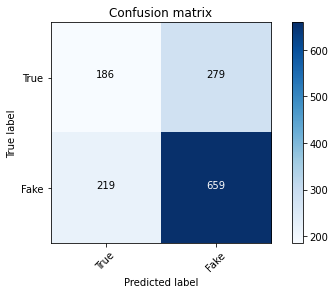

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def NB_text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    STEMMER = SnowballStemmer('english')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([STEMMER.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

def NB_preprocessing(data):
    ''' Return train, validation and test set '''
    X = data['statement'].tolist()
    X = [NB_text_processing(txt) for txt in X]
    cv = CountVectorizer(max_features = 5000)

    X = cv.fit_transform(X).toarray()
    Y = data['label'].tolist()
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85)
    print('train len:', len(x_train))
    print('test len:', len(x_test))

    return x_train, x_test, y_train, y_test

def NB_Model(data):
    ''' Create a model based on Naive Bayes '''
    x_train, x_test, y_train, y_test = NB_preprocessing(data)
    classifier = MultinomialNB()
    classifier.fit(x_train, y_train)

    y_pred = classifier.predict(x_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['True', 'Fake'])

NB_Model(data)

The accuracy is 62.92% which is pretty good knowing that we are using Naive Baye, sometimes the simplest solutions are the best, but we need to improve this result.

But we can notice that the model is more confident in classifying fake news than true information.

<h3> Part II - LSTM Classification: </h3>

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

X = data['statement'].apply(lambda x: NB_text_processing(x))
Y = data['label'].tolist()
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y.reshape(-1, 1)
print(X)

c=[]
for i in range(len(X)):
    m=len(X[i].split())
    c.append(m)
print('Maximum length of a sentence is : ',max(c))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen = max(c))
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85)

0       china south china sea build militari fortress ...
1       resourc take execut three month iraq war could...
2           wisconsin governor propos tax giveaway corpor
3       say represent exboyfriend friend famili law ca...
4       protest wisconsin propos collect bargain chang...
                              ...                        
8945    rhode island hybrid retir plan well first stat...
8946    new health care law forc senior barack obama g...
8947    health insur plan member congress differ feder...
8948    one american histori move june 16 announc may ...
8949         say armi spend 7 million sponsor nascar team
Name: statement, Length: 8950, dtype: object
Maximum length of a sentence is :  227
Vocabulary Size : 8636


In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

''' You have to download this file: http://nlp.stanford.edu/data/glove.6B.zip
    his weight is 1GO !'''

EMBEDDING_DIM = 300
BATCH_SIZE = 512

embeddings_index = {}

f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(vocab_size
    , EMBEDDING_DIM
    , weights=[embedding_matrix]
    , input_length=max(c)
    , trainable=False)

Found 400000 word vectors.


In [7]:
import tensorflow as tf

def MakeModel():
    sequence_input = Input(shape=(max(c),), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(sequence_input, outputs)
    print(model.summary())
    return model

model = MakeModel()
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 227, 300)          2590800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 227, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 223, 64)           96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [8]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=4, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau, model_checkpoint_callback])

Epoch 1/4
15/15 [==============================] - 87s 5s/step - loss: 0.6553 - accuracy: 0.6309 - val_loss: 0.6288 - val_accuracy: 0.6724
Epoch 2/4
15/15 [==============================] - 76s 5s/step - loss: 0.6359 - accuracy: 0.6426 - val_loss: 0.6267 - val_accuracy: 0.6828
Epoch 3/4
15/15 [==============================] - 81s 5s/step - loss: 0.6238 - accuracy: 0.6535 - val_loss: 0.6200 - val_accuracy: 0.6813
Epoch 4/4
15/15 [==============================] - 76s 5s/step - loss: 0.6069 - accuracy: 0.6693 - val_loss: 0.6200 - val_accuracy: 0.6716


Accuracy: 0.6716306775874907
F1 score: 0.7876745305729417


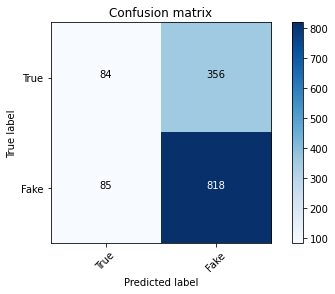

In [9]:
threshold = 0.5

y_tmp = model.predict(x_test)
y_pred = []
for i in range(len(y_tmp)):
    if(y_tmp[i] > threshold): y_pred.append(1)
    else: y_pred.append(0)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['True', 'Fake'])

Sadly the LSTM model tend to predict a lot of Fake news.

Though the accuracy is a bit better than Naive Baye with 67.16%

<h3> Part III - Bert Classification: </h3>

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

def Bert_preprocess_text(text, device, tokenizer):
    ''' Split text in chunks of 'delta' words strictly then encode it'''
    parts = []
    text_len = len(text.split(' '))
    delta = 200
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

def Bert_train_epoch(model, x_train, y_train, loss_fn, optimizer, device, tokenizer):
    ''' Train Bert model for one epoch '''
    print_every = 300; total_loss = 0
    all_losses = []
    model.train()
    correct_predictions = 0
    for idx in range(len(x_train)):
        text_parts = Bert_preprocess_text(x_train[idx], device, tokenizer)
        label = torch.tensor([y_train[idx]]).long().to(device)
        overall_output = torch.zeros(2).float().to(device)
        for part in text_parts:
            if len(part) > 0:
                try:
                    input = part.reshape(-1)[:512].reshape(1, -1)
                    overall_output += (model(input, labels=label)[1].float().to(device))[0]
                except Exception as e:
                    print(str(e))
        correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
        if label == 0: label = torch.tensor([1.0, 0.0]).float().to(device)
        elif label == 1: label = torch.tensor([0.0, 1.0]).float().to(device)
        loss = loss_fn(overall_output, label)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % print_every == 0 and idx > 0:
            average_loss = total_loss / print_every
            print("{}/{}. Average loss: {} | Accuracy: {}%".format(idx, len(x_train), average_loss, (correct_predictions/idx)*100))
            all_losses.append(average_loss)
            total_loss = 0
            
def Bert_eval_model(model, x_val, y_val, loss_fn, device, tokenizer):
    ''' Evaluate Bert model on validation data '''
    total_loss = 0; all_losses = []
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for idx in range(len(x_val)):
            text_parts = Bert_preprocess_text(x_val[idx], device, tokenizer)
            label = torch.tensor([y_val[idx]]).long().to(device)
            overall_output = torch.zeros(2).float().to(device)
            for part in text_parts:
                if len(part) > 0:
                    try:
                        input = part.reshape(-1)[:512].reshape(1, -1)
                        overall_output += (model(input, labels=label)[1].float().to(device))[0]
                    except Exception as e:
                        print(str(e))
            correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
            if label == 0: label = torch.tensor([1.0, 0.0]).float().to(device)
            elif label == 1: label = torch.tensor([0.0, 1.0]).float().to(device)
            loss = loss_fn(overall_output, label)
            total_loss += loss.item()
        average_loss = total_loss / len(x_val)
        print("Average val loss: {} | Val accuracy: {}%".format(average_loss, (correct_predictions/len(x_val))*100))
        all_losses.append(average_loss)
        total_loss = 0
    

def Bert_train_model(X, Y):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    x, x_test, y, y_test = train_test_split(X,Y,test_size=0.05,train_size=0.95)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.15,train_size=0.85)
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
    model.config.num_labels = 1
    for param in model.parameters():
        param.requires_grad = False #Freeze Bert !
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 2),
        nn.Softmax(dim=1)
    )
    model = model.to(device)
    
    criterion = nn.BCELoss().to(device)
    optimizer = optim.AdamW(model.classifier.parameters(), lr=3e-5)
    
    EPOCHS = 3
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        Bert_train_epoch(model, x_train, y_train, criterion, optimizer, device, tokenizer)
        Bert_eval_model(model, x_val, y_val, criterion, device, tokenizer)
        
X = data['statement'].tolist()
Y = data['label'].tolist()
Bert_train_model(X, Y)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1/3
----------
300/7226. Average loss: 0.6639546110232671 | Accuracy: 63.0%
600/7226. Average loss: 0.6519798828164737 | Accuracy: 64.5%
900/7226. Average loss: 0.6680497904618581 | Accuracy: 63.888888888888886%
1200/7226. Average loss: 0.6817441352208455 | Accuracy: 62.25000000000001%
1500/7226. Average loss: 0.6544746200243632 | Accuracy: 62.46666666666667%
1800/7226. Average loss: 0.6578336762388547 | Accuracy: 62.83333333333333%
2100/7226. Average loss: 0.6540734585126241 | Accuracy: 62.95238095238095%
2400/7226. Average loss: 0.6374216807385286 | Accuracy: 63.33333333333333%
2700/7226. Average loss: 0.6617439130942027 | Accuracy: 63.33333333333333%
3000/7226. Average loss: 0.6675263519088427 | Accuracy: 63.26666666666667%
3300/7226. Average loss: 0.6334609126051267 | Accuracy: 63.66666666666667%
3600/7226. Average loss: 0.6613467560211818 | Accuracy: 63.55555555555556%
3900/7226. Average loss: 0.6705454394221306 | Accuracy: 63.43589743589744%
4200/7226. Average loss: 0.6062

As we can see the model is learning nothing from Fake news because the problem with fake news is that you can't classify it based only on text, you also need context.